<a href="https://colab.research.google.com/github/kaisarmasum/Quantum-Machine-Learning/blob/main/Hybrid_QNN_%2B_VQC_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
%matplotlib inline

In [ ]:
import pandas as pd
#df =  pd.read_csv("Twitter.csv",sep="\t")
#df = pd.read_csv("spamdata.csv")
#df = pd.read_fwf("/content/sst2.txt", sep=" ", header=None)
df = pd.read_csv("IMDB.csv")

In [ ]:
len(df)

5000

In [ ]:
#df.columns = ["label", "text"]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
"""df = df.drop("News Type", axis=1)
df.head()"""

'df = df.drop("News Type", axis=1)\ndf.head()'

In [ ]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
df.sentiment = l.fit_transform(df.sentiment)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
x = df['review']
y = df['sentiment']
x.shape

(5000,)

In [ ]:
x.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [ ]:
train_text, test_text, train_y, test_y = train_test_split(x,y,test_size = 0.2)

In [ ]:
MAX_NB_WORDS = 8000
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 39183 unique tokens.


In [ ]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 39183)

In [ ]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[0]])

"i don't remember this film getting a cinema release over here i only saw it when it came onto cable the film deals with the of children into killing machines specifically one person the way he gets replaced and dumped literally into an off world community where he finds himself unable to cope with coming to terms with who he really is and what he feels br br seems to me that a lot of people expected this to be rambo in space and would have been happy if it was br br i'm certainly happy it kurt does a fine job of portraying an emotional cripple the scene where he's sitting outside the shows this albeit the decision for two slow mo detracts from the moment br br this is not a classic sf movie in the way that alien silent running run or were however it is unfortunately the nearest i've seen to it in a long time br br he changes in the movie to a believable degree he crack one liners he become snake and there is no happy ending br br that's why this film do well it follow formula and amon

In [ ]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 220.5
max length: 1544


In [ ]:
MAX_SEQUENCE_LENGTH = max(seq_lens) # round(np.mean(seq_lens))

x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (4000, 1544)
Shape of data test tensor: (1000, 1544)


In [ ]:
x_train

array([[   0,    0,    0, ...,    7,    7,  205],
       [   0,    0,    0, ...,  246,   16,    1],
       [   0,    0,    0, ...,   10,  382,   15],
       ...,
       [   0,    0,    0, ...,   33, 2541,   70],
       [   0,    0,    0, ...,   16,  257,  717],
       [   0,    0,    0, ..., 6700,    5,   70]], dtype=int32)

In [ ]:
x_train.shape

(4000, 1544)

In [ ]:
y_train = train_y
y_test = test_y

y_train = tf.keras.utils.to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (4000, 2)


## Classical QNN

In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)

predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
%%time
model.fit(x_train, y_train, validation_split=0.1,epochs=30, batch_size=128)

Epoch 1/30
29/29 [==============================] - 12s 279ms/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6926 - val_acc: 0.5375
Epoch 2/30
29/29 [==============================] - 9s 292ms/step - loss: 0.6926 - acc: 0.5214 - val_loss: 0.6922 - val_acc: 0.5500
Epoch 3/30
29/29 [==============================] - 7s 252ms/step - loss: 0.6922 - acc: 0.5717 - val_loss: 0.6917 - val_acc: 0.5825
Epoch 4/30
29/29 [==============================] - 5s 158ms/step - loss: 0.6916 - acc: 0.5464 - val_loss: 0.6914 - val_acc: 0.4950
Epoch 5/30
29/29 [==============================] - 5s 177ms/step - loss: 0.6907 - acc: 0.6117 - val_loss: 0.6902 - val_acc: 0.6750
Epoch 6/30
29/29 [==============================] - 6s 197ms/step - loss: 0.6897 - acc: 0.6372 - val_loss: 0.6890 - val_acc: 0.7175
Epoch 7/30
29/29 [==============================] - 3s 111ms/step - loss: 0.6884 - acc: 0.7569 - val_loss: 0.6877 - val_acc: 0.7975
Epoch 8/30
29/29 [==============================] - 2s 86ms/step - loss: 0.

In [ ]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

32/32 [==============================] - 0s 6ms/step
test auc: 0.858818956639512


##Output Analysis

In [ ]:
from keras.models import Model

# Create a model with multiple outputs, including intermediate layers
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.layers[0].output,model.layers[1].output,  # Embedding output
                                          model.layers[2].output,  # Average pooling output
                                          model.layers[3].output])  # Final predictions

intermediate_outputs = intermediate_layer_model.predict(x_train)
print("Input",intermediate_outputs[0])  # Embedding output
print("Embedding output",intermediate_outputs[1])  # Embedding output
print("Average pooling output",intermediate_outputs[2])  # Average pooling output
print("Final predictions",intermediate_outputs[3])  # Final predictions

125/125 [==============================] - 3s 24ms/step
Input [[   0    0    0 ...    7    7  205]
 [   0    0    0 ...  246   16    1]
 [   0    0    0 ...   10  382   15]
 ...
 [   0    0    0 ...   33 2541   70]
 [   0    0    0 ...   16  257  717]
 [   0    0    0 ... 6700    5   70]]
Embedding output [[[-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  ...
  [-0.34386683  0.36889476  0.3282125  ...  0.4252723  -0.3499001
    0.33324236]
  [-0.34386683  0.36889476  0.3282125  ...  0.4252723  -0.3499001
    0.33324236]
  [ 0.64113075 -0.65493846 -0.5991511  ... -0.6951273   0.6288959
   -0.60556376]]

 [[-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802

In [ ]:
intermediate_layer_model = Model(inputs=model.input, outputs=[model.layers[1].output])  # Embedding output only
embedded_sequences_data = intermediate_layer_model.predict(x_train)
print(embedded_sequences_data)

125/125 [==============================] - 1s 6ms/step
[[[-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  ...
  [-0.34386683  0.36889476  0.3282125  ...  0.4252723  -0.3499001
    0.33324236]
  [-0.34386683  0.36889476  0.3282125  ...  0.4252723  -0.3499001
    0.33324236]
  [ 0.64113075 -0.65493846 -0.5991511  ... -0.6951273   0.6288959
   -0.60556376]]

 [[-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  [-0.00653016 -0.044802   -0.04898064 ... -0.00343075  0.03042285
    0.01920886]
  ...
  [-0.40624246  0.31097     0.3690395  ...  0.41731375 -0.388136
    0.3930401 ]
  [ 0.1772849  -0.15955982 -0.13814467 ... -0.07935683  0.08329388
   -0.11699436]
  [ 0.06164036 -0.07300

In [ ]:
print(embedded_sequences_data.shape)

(4000, 1544, 50)


In [ ]:
intermediate_layer_model = Model(inputs=model.input, outputs=[model.layers[2].output])  # Pooling output only
pooling_output_train_data = intermediate_layer_model.predict(x_train)
print(pooling_output_train_data)
pooling_output_test_data = intermediate_layer_model.predict(x_test)

125/125 [==============================] - 1s 10ms/step
[[-0.00613031 -0.0369159  -0.0413525  ... -0.00181832  0.02472388
   0.01669074]
 [-0.01042742 -0.03712113 -0.04177175 ...  0.00109985  0.02370647
   0.02111359]
 [-0.01884723 -0.02951536 -0.03388659 ...  0.00972566  0.01644816
   0.02887138]
 ...
 [ 0.00925293 -0.05205089 -0.05550193 ... -0.01789498  0.03937653
   0.00400727]
 [ 0.00654129 -0.05067044 -0.05461466 ... -0.01560934  0.03736667
   0.00580996]
 [ 0.00135816 -0.04804847 -0.0521517  ... -0.01096773  0.03481157
   0.01060938]]
32/32 [==============================] - 0s 5ms/step


In [ ]:
print(pooling_output_train_data.shape)

(4000, 50)


## PCA

In [ ]:
from sklearn.decomposition import KernelPCA
kernel_pca_rbf = KernelPCA(n_components=4, kernel="rbf")
kernel_pca_rbf.fit(pooling_output_train_data)
train_features_rbf = kernel_pca_rbf.transform(pooling_output_train_data)
kernel_pca_rbf.fit(pooling_output_test_data)
test_features_rbf = kernel_pca_rbf.transform(pooling_output_test_data)

In [ ]:
train_features_rbf

array([[-2.3042392e-03,  5.8165879e-04,  1.8383693e-03, -2.4917442e-04],
       [ 2.4206678e-03, -2.2977509e-03,  2.0879887e-03,  7.1567018e-05],
       [ 1.3486461e-02, -2.4994197e-03,  2.2223678e-03, -2.2942200e-04],
       ...,
       [-2.2545336e-02, -2.2295336e-04,  2.3538801e-03, -1.3687834e-04],
       [-1.9820744e-02, -3.6480586e-04,  2.2453973e-03,  2.3800135e-04],
       [-1.3606444e-02, -1.9577881e-03,  2.2272104e-03,  2.1123048e-04]],
      dtype=float32)

In [ ]:
!pip install qiskit==0.45.2

In [ ]:
from qiskit.circuit.library import ZZFeatureMap,PauliFeatureMap
num_features = train_features_rbf.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement = 'linear',
insert_barriers =True)
feature_map.draw()

┌────────────────────────────────────┐
q_0: ┤0                                   ├
     │                                    │
q_1: ┤1                                   ├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤2                                   ├
     │                                    │
q_3: ┤3                                   ├
     └────────────────────────────────────┘

In [ ]:
print(feature_map.decompose().decompose().depth())

11


In [ ]:
!pip install qiskit_machine_learning

In [ ]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
#ansatz.decompose().draw(output="mpl", fold=20)

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

count = 0
def callback_graph(weights, obj_func_eval):
    global count
    count+=1
    print(count)
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import ISRES, ADAM, COBYLA
from qiskit.primitives import Sampler

sampler = Sampler()
optimizer = COBYLA(maxiter=10)

<ipython-input-35-fcb15338e3bc>:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ISRES, ADAM, COBYLA


# Neural Network with VQC

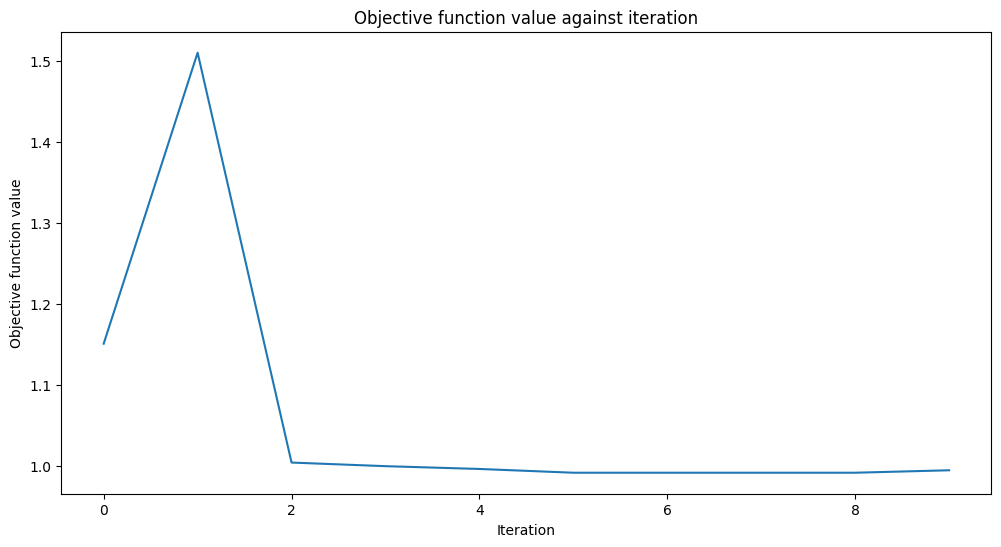

CPU times: user 3min 19s, sys: 2.19 s, total: 3min 21s
Wall time: 3min 43s


In [ ]:
%%time
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals = []
vqc.fit(train_features_rbf, y_train)

In [ ]:
train_score_q4 = vqc.score(train_features_rbf, y_train)
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")

Quantum VQC on the training dataset: 0.50


In [ ]:
y_test = tf.keras.utils.to_categorical(np.asarray(y_test))
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (1000, 2)


In [ ]:
train_score_q4 = vqc.score(train_features_rbf, y_train)
test_score_q4 = vqc.score(test_features_rbf, y_test)
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.50
Quantum VQC on the test dataset:     0.52


# Neural Network with QNN

In [ ]:
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.algorithms.optimizers import ISRES, ADAM, COBYLA
from qiskit import QuantumCircuit

In [ ]:
qc = QuantumCircuit(num_features)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw()

┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────┐
«q_0: ┤0                                                         ├
«     │                                                          │
«q_1: ┤1                                                         ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
«q_2: ┤2                                                         ├
«     │                                                          │
«q_3: ┤3                                                         ├
«     └──────────────────────────────────────────────────────────┘

In [ ]:
parity = lambda x: format(x, 'b').zfill(2).count('1') % 2

In [ ]:
qnn = SamplerQNN(
    circuit = qc,
    input_params = feature_map.parameters,
    weight_params = ansatz.parameters,
    interpret = parity,
    output_shape = 2
)

In [ ]:
x_train.shape

(4000, 1544)

In [ ]:
%%time
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)

estimator_classifier = NeuralNetworkClassifier(
    qnn, optimizer=optimizer, callback=callback_graph
)
estimator_classifier.fit(train_features_rbf, train_y)

CPU times: user 3min 10s, sys: 890 ms, total: 3min 11s
Wall time: 3min 15s


In [ ]:
train_score_q4 = estimator_classifier.score(train_features_rbf, train_y)
print("QNN_Train_Accuracy",train_score_q4)
test_score_q4 = estimator_classifier.score(test_features_rbf, test_y)
print("QNN_Test_Accuracy",test_score_q4)

QNN_Train_Accuracy 0.49725
QNN_Test_Accuracy 0.479
